In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx import circuit
from pyzx import *
from pyzx.parity_maps import CNOT_tracker, build_random_parity_map
from pyzx.linalg import Mat2
from pyzx.simplify import full_reduce

Load Circuits for CombRowCol

In [17]:
comb_circuit_folder = "../circuits/combs-ZX/"

n_qubits = [4]
n_cnots = [4]
n_non_cnots = [2]
loaded_circuits = {}
for qubits in n_qubits:
    for cnots in n_cnots:
        for non_cnots in n_non_cnots:
            circuit_properties = {"Qubits"    : qubits,
                                  "CNOTs"     : cnots,
                                  "Non-CNOTs" : non_cnots}
            path = os.path.join(comb_circuit_folder,
                                str(circuit_properties["Qubits"])+"qubits", 
                                str(circuit_properties["CNOTs"])+"cnots", 
                                str(circuit_properties["Non-CNOTs"])+"non-cnots")
            loaded_circuits[f"({qubits},{cnots},{non_cnots})"] = []
            if os.path.exists(path):
                for file_name in os.listdir(path):
                    loaded_circuits[f"({qubits},{cnots},{non_cnots})"].append(circuit.Circuit.from_qasm_file(os.path.join(path, file_name)))
            else:
                print("Directory Does Not Exist")

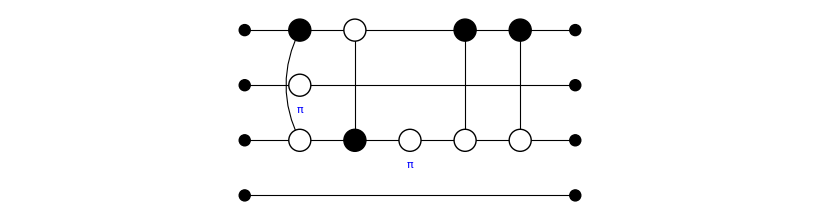

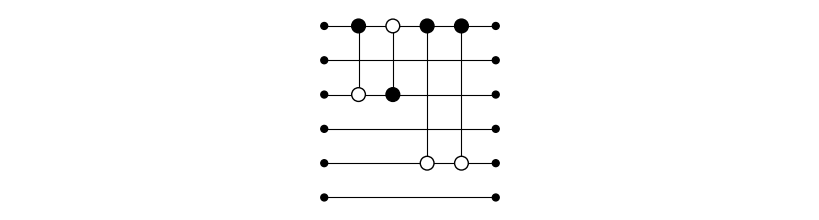

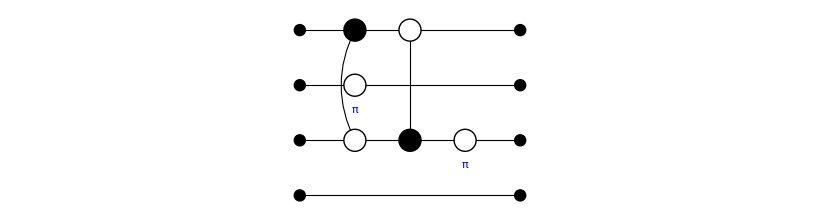

Qubits : 4, CNOTs : 4, Non-CNOTs : 2 -> 1, Overhead : -0.5


In [18]:
from IPython.display import display, Markdown

DEBUG = False
OUTER_DISPLAY = True
INNTER_DISPLAY = False

for qubits in n_qubits:
    for cnots in n_cnots:
        for non_cnots in n_non_cnots:
            arch = architecture.create_architecture(architecture.FULLY_CONNNECTED, n_qubits=qubits)
            equal = 0
            overhead = []
            for INDEX in [20]: #range(100):
                if False:
                    # Get circuit
                    circ = loaded_circuits[f"({qubits},{cnots},{non_cnots})"][INDEX]
                    # Draw circuit
                    OUTER_DISPLAY and display(zx.draw(circ))
                    # Decompose circuit into comb and holes
                    decomposition = CombDecomposition.from_circuit(circ.copy())
                    comb = decomposition.comb
                    # Draw comb
                    OUTER_DISPLAY and display(zx.draw(comb))
                    # Recompose circuit from comb and holes
                    new_circuit = CombDecomposition.to_circuit(decomposition)
                    # Display recomposed circuit
                    OUTER_DISPLAY and display(zx.draw(new_circuit))
                    # Check whether the recomposed circuit is the same as the original
                    equality = new_circuit.verify_equality(circ)
                    equal += equality
                else:
                    circ = loaded_circuits[f"({qubits},{cnots},{non_cnots})"][INDEX]
                    new_circ, Id = combrowcol(circ, arch, DEBUG, OUTER_DISPLAY, INNTER_DISPLAY)
                    overhead.append((len(new_circ.gates)-non_cnots)/(len(circ.gates)-non_cnots) - 1)
                    equality = new_circ.verify_equality(circ)
                    equal += equality
                    #print(f"INDEX: {INDEX} , GATE RATIO : {gate_ratio}")
                    #print(f"INDEX: {INDEX} {equality}")
                    #equal += Id
                    #print(f"Reduced to identity : {INDEX} {Id}")
            print(f"Qubits : {qubits}, CNOTs : {cnots}, Non-CNOTs : {non_cnots} -> {equal}, Overhead : {sum(overhead)/len(overhead)}")

In [14]:
arch.graph

Graph(4 vertices, 4 edges)